# Texture Synthesis with CNNs in PyTorch

                    Goupe : Rida LEFDALI | Cristiano Ulondu Mendes | Sandy Frank Ngaha 

The following code is an implemetation in **Pytorch** of the article _Texture Synthesis using Convolutional Neural Network_ (http://arxiv.org/abs/1505.07376) 

The code is taken from the following github repository : https://github.com/trsvchn/deep-textures

# Import libraries and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torchvision.transforms.functional import normalize

from PIL import Image
import matplotlib.pyplot as plt

from deeptextures import vgg19, gram_loss
from deeptextures.utils import set_seed, set_device, prep_img, to_pil, MEAN, STD

# Texture Synthesis Using VGG-19

In this section we are trying to generate synthetized texture using the pre-trained VGG-19, that exists already in pytorch library. 

In this section we are trying to explain the code, if you want to test the code please use the cells of the section _**Test**_ with the images of the folder _**imagetest**_. 

The image used for the experience in our report (section Implementation and Results) are in the folder _**original**_ and the results are in the folder _**texture_gen**_

### Setting the parameters

we set the parameters that we are going to use to generate a synthetised texture. 

the parameteres are the following:
    
    1. image: the path of the original image 
    
    2. layers: a list that contains the name of the layers. As example you can use the following list:
                                ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
               but you can include other layers. we will compute only feature maps of these layers to generate 
               the new synthetized texture. 
    
    3. layers_waeights: a list that contains the weight of each layer 
    
    4. img_size: the new size of the original image
    
    5. log_every: after each log_every iterations we print the value of loss function
    
    6. seed : is a parametrer for random generation of number

In [ ]:
image = "original/rose.jpg" # the original image that we use to generate a synthetized texture
img_size = 256 #
n_iters = 2000
layers = ["conv1_1", "pool1", "pool2", "pool3", "pool4"] # the name of the layers that we are going to use 
layers_weigths = [1e9] * len(layers)
log_every = 200
seed = 0

# Set device and a seed
device = set_device() # here we try to use gpu if exists otherwise we use cpu 
set_seed(seed)


### We import the model VGG-19

We import the pre-trained VGG-19 model. As in the article, they use for this method a VGG-19 to compute the feature maps for the original image and the new synthetized texture.  

In [ ]:
# Init model
model = vgg19().to(device)

### Prepare the original image

 We resize the originale image to have as size (256,256)

In [ ]:
target = prep_img(image, img_size).to(device) # the function prep_img exists in the file deeptextures/utils.py

### Initial noise

Here we generate the initial noise that we are going to use to generate the synthetized texture. As in the article, they take a noise and they start to improve it through the VGG-19 until we get close to the original texture

In [ ]:
# Init input image 

# MEAN = (0.485, 0.456, 0.406)
# STD = (0.229, 0.224, 0.225)

synth = torch.randint_like(target, 0, 256) # we generate a tensor with random integers between 0 and 255
synth = synth.div(255) # divide the element of the tenseor by 255 to get values between 0 and 1 
synth = normalize(synth, MEAN, STD) # we normalize the noise
synth.requires_grad_(True)

### Setting the optimizer

Here we set the optimizer to **LBFGS**. We can use **ADAM** optimizer ( uncomment the other variable _optimizer_ ). At each step of the optimization, the variable _**synth**_ , which is the initial noise, will have a new value.

In [4]:
# Set optimizer
optimizer = optim.LBFGS(
    [synth],
    tolerance_grad=0.0,
    tolerance_change=0.0,
    line_search_fn="strong_wolfe",
)

#optimizer = optim.Adam([synth], lr=0.1)

In the following cell, we are going to minimize the loss function. At each iteration the function _closure()_ inside the while loop compute the value of the total loss.

1. we get the feature maps of the defined layers computed by the model VGG-19 for the original image.
2. The while loop is for optimizing the Loss function, at each iteration:

    - We get the feature maps of the defined layers for the new synthesized texture (which is a noise) by the function _closure()_
    - we compute the gram matrixes and the value of the loss by the function _closure()_  
    - We optimize the loss function by the defined optimizer.

Then, we save the texture synthetized in the folder **textures_gen**

0 3433014016.0


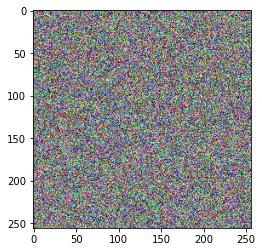

200 774195.75


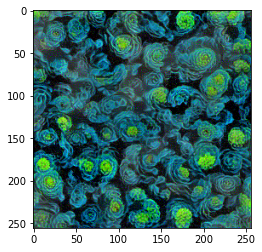

400 286219.59375


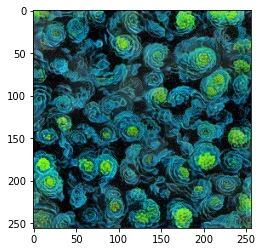

600 194598.984375


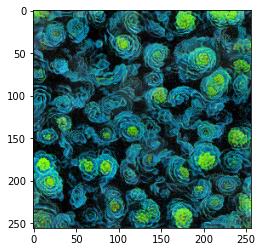

800 160002.21875


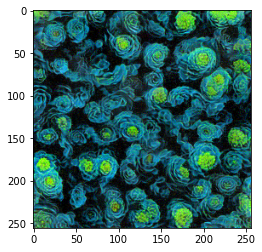

1000 141994.5


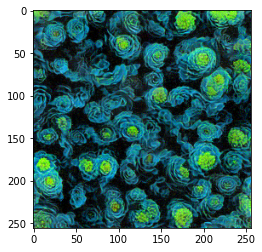

1200 131147.140625


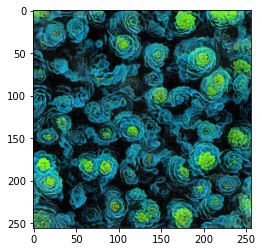

1400 123602.3515625


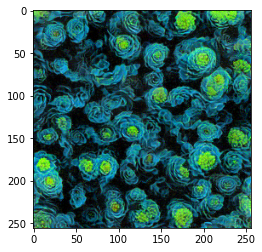

1600 118130.6484375


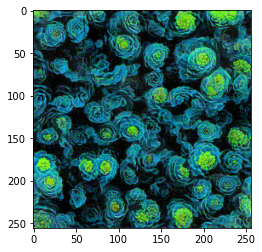

1800 113958.5


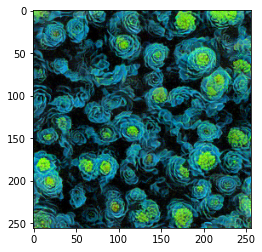

2000 110652.6875


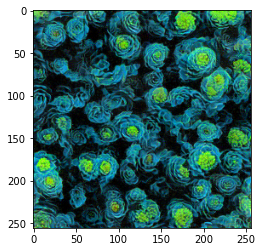

In [58]:
# Get feature maps for the target texture
target_activations = [*model(target, layers)]
iter_ = 0
while iter_ <= n_iters:

    def closure():
        global iter_

        optimizer.zero_grad()

        synth_activations = [*model(synth, layers)]

        assert len(synth_activations) == len(target_activations) == len(layers_weigths)
        
        # Compute loss for each activation
        losses = []
        for activations in zip(synth_activations, target_activations, layers_weigths):
            losses.append(gram_loss(*activations).unsqueeze(0))

        total_loss = torch.cat(losses).sum()
        total_loss.backward()

        if iter_ == 0 or iter_ % log_every == 0:
            # Print loss value
            print( 'Step [{}/{}], Loss: {:.4f}' .format( iter_, n_iters, total_loss.item()))
            
            # Show image
            plt.imshow(to_pil(synth.squeeze(0)))
            plt.show()

        iter_ += 1

        return total_loss

    optimizer.step(closure)


# Save generated texture
to_pil(synth.squeeze()).save("textures_gen/rose_pool4_gen.png")

In [13]:
layers_name = ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
image_name = ["pebbles", "ground", "rose", "cat"]
path = "textures_gen/"
prefix = "_adam.png"
orig_path = "original/"

def Show_layer_result(layer_name):
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(1, 5):
        img = plt.imread(path+image_name[i-1]+"_"+layer_name+prefix)
        fig.add_subplot(1, 4, i)
        plt.imshow(img) 
        plt.title(image_name[i-1]+"_"+layer_name)
    plt.show()
    

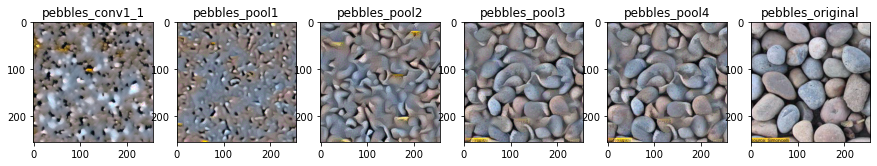

In [15]:
fig = plt.figure(figsize=(15, 15))


        
for i in range(1, 6):
    img = plt.imread(path+"pebbles"+"_"+layers_name[i-1]+prefix)
    fig.add_subplot(1, 6, i)
    plt.imshow(img) 
    plt.title("pebbles"+"_"+layers_name[i-1])

img = plt.imread(orig_path+"pebbles"+".jpg")
fig.add_subplot(1, 6, 6)
plt.imshow(img) 
plt.title("pebbles"+"_original")

plt.show()

In [5]:
def Show_original():
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(1, 5):
        img = plt.imread(orig_path+image_name[i-1]+".jpg")
        fig.add_subplot(1, 4, i)
        plt.imshow(img) 
        plt.title(image_name[i-1]+"_original")
    
    plt.show()
    

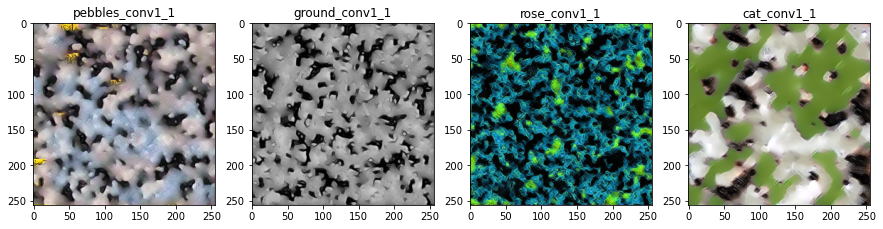

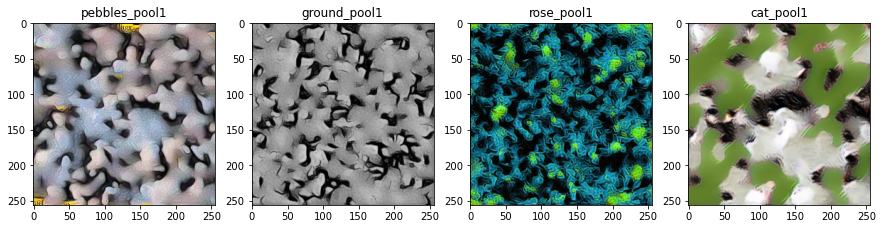

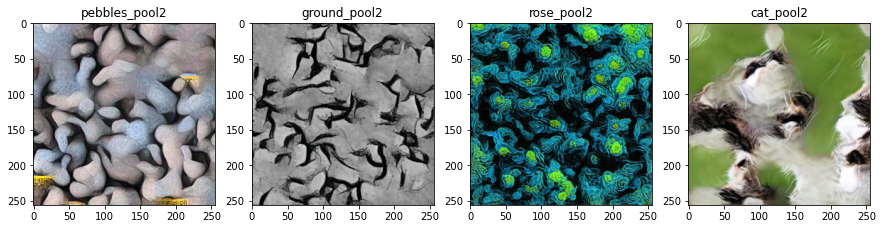

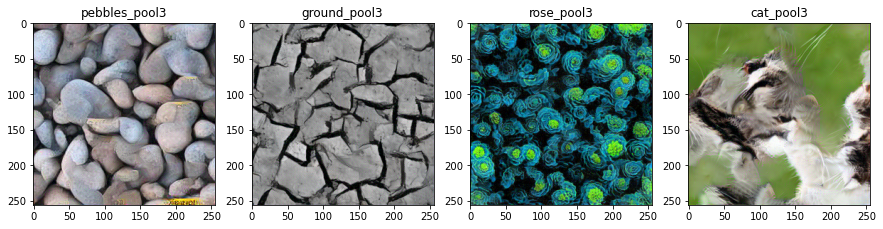

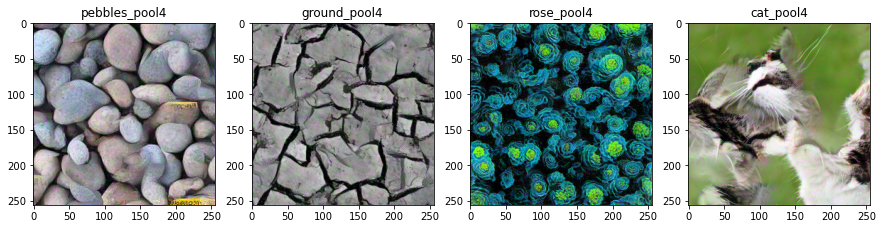

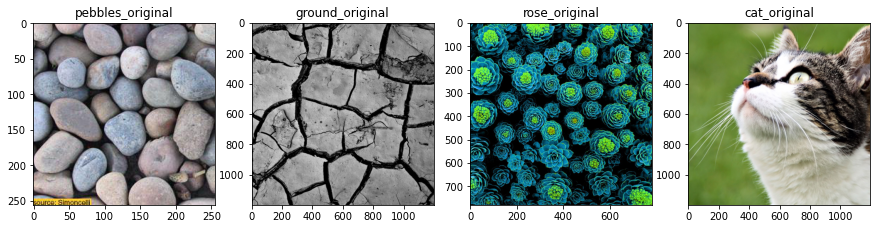

In [7]:
Show_layer_result(layers_name[0])
Show_layer_result(layers_name[1])
Show_layer_result(layers_name[2])
Show_layer_result(layers_name[3])
Show_layer_result(layers_name[4])
Show_original()

# Test 

In this section we set in the first cell all the needed parametres to execute the convolutional neural network.

the parameters that you can set:
    1. image :  the path of the original image
    2. layers : the name of the layers that you want to use to compute the features maps.
                the layers name : conv1_1, conv1_2, pool1, conv2_1, conv2_2, pool2, conv3_1, conv3_2, conv3_3, conv3_4, 
                pool3, conv4_1, conv4_2, conv4_3, conv4_4, pool4, conv5_1, conv5_2, conv5_3, conv5_4, pool5,
    3. layers_waights : the weights of each layer

then execute the cells to get a new synthetised texture 

In [20]:
seed = 0
log_every = 200

image = "imagetest/texture_3.jpg" # the path original image that we use to generate a synthetized texture
img_size = 256 
n_iters = 2000

layers = ["conv1_1", "pool1", "pool2", "pool3", "pool4"] # the name of the layers that we are going to use 
  
layers_weigths = [1] * len(layers) # the weights of the layers 

Step [0/2000], Loss: 3.9996
Step [200/2000], Loss: 0.0323
Step [400/2000], Loss: 0.0077
Step [600/2000], Loss: 0.0025
Step [800/2000], Loss: 0.0013
Step [1000/2000], Loss: 0.0008
Step [1200/2000], Loss: 0.0006
Step [1400/2000], Loss: 0.0005
Step [1600/2000], Loss: 0.0004
Step [1800/2000], Loss: 0.0004
Step [2000/2000], Loss: 0.0004


<Figure size 1080x1080 with 0 Axes>

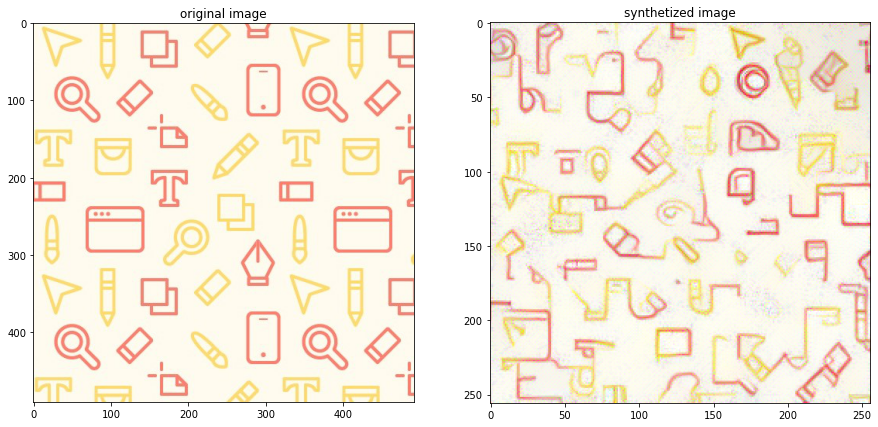

In [21]:
#---------- Set device and a seed ---------------

device = set_device() # here we try to use gpu if exists otherwise we use cpu 
set_seed(seed)

# ------------- Init model--------------------

model = vgg19().to(device)


#------------ prepare the original image ---------------------

target = prep_img(image, img_size).to(device)

#-------------- Define the initial noise ------------------------------

synth = torch.randint_like(target, 0, 256) # we generate a tensor with random integers between 0 and 255
synth = synth.div(255) # divide the element of the tenseor by 255
synth = normalize(synth, MEAN, STD) # we normalize the noise
synth.requires_grad_(True)

#------------------ Set the otpimizer ------------------------------ 

optimizer = optim.LBFGS(
    [synth],
    tolerance_grad=0.0,
    tolerance_change=0.0,
    line_search_fn="strong_wolfe",
)


# optimizer = optim.Adam([synth], lr=0.1)  # uncomment this line if you want to use ADAM otpimizer



#--------------------- Get feature maps for the original image -----------------------------

target_activations = [*model(target, layers)]


#----------------------- Optimization while loop ---------------------------------------- 

iter_ = 0

while iter_ <= n_iters:

    def closure():
        global iter_

        optimizer.zero_grad()

        synth_activations = [*model(synth, layers)] # Get feature maps for the synthetized image

        assert len(synth_activations) == len(target_activations) == len(layers_weigths)

        # Compute loss for each activation
        
        losses = []
        for activations in zip(synth_activations, target_activations, layers_weigths):
            losses.append(gram_loss(*activations).unsqueeze(0))

        total_loss = torch.cat(losses).sum()
        total_loss.backward()

        if iter_ == 0 or iter_ % log_every == 0:

            # Print loss value
            print( 'Step [{}/{}], Loss: {:.4f}' .format(iter_, n_iters, total_loss.item()))

        iter_ += 1

        return total_loss

    optimizer.step(closure)

    
# ------------------------ Show images -----------------------------------------

fig = plt.figure(figsize=(15, 15))

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
plt.imshow(plt.imread(image))
plt.title("original image")

fig.add_subplot(1, 2, 2)
plt.imshow(to_pil(synth.squeeze()))
plt.title("synthetized image")

plt.show()
